In [6]:
import daymetpy
import pandas as pd
import os
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.ticker as tick
import textwrap

In [8]:
events = pd.read_csv('~/DATA/Project2/Rainfall_Data_New.csv')
events.EVENT_DATE = pd.to_datetime(events.EVENT_DATE)
regions = events.Region.unique().tolist()

def process_event_clusters(cluster_df):
    
    cluster_df['day_window'] = cluster_df.date_window.dt.strftime('%j').astype('int64')
    
    grouped = cluster_df.groupby(['region', 'event'])
    
    #assigning event numbers
    new_event_number = 0
    
    for region, event in grouped:
        #print(region,event.index)
        cluster_df.loc[event.index, 'new_event_number'] = new_event_number
        #print(cluster.loc[event.index, 'new_event_number'])
        new_event_number += 1
        
    print(f"number of events with clusters is {new_event_number}")
    
    return new_event_number, cluster_df

#for plotting wet year clusters only

def modify_plot_forwetyear(cluster_df):
    
    # preprocessing events occurring before March for plotting
    cluster_march = cluster_df[cluster_df.day_window < 100]
    
    # add a year to plot wet year oct-march
    newday = cluster_march.day_window + 365
    cluster_df.loc[cluster_df.index.isin(newday.index), 'day_window'] = newday
    newdates = []
    
    # Adjust the day for events in the first 150 days of the year. They have to be modified to plot oct-march in the same plot without stop in Dec
    newdates = []
    for i in cluster_df.event_date.dt.strftime('%j').astype('int64'):
        if i < 150:
            newdate = i + 365
        else:
            newdate = i
        newdates.append(newdate)
        
    cluster_df['event_date_day'] = newdates
    
    return cluster_df

#cluster analysis

dates_cluster = []

for j in range(0,len(events)):
    print(j)
    
    #query for daymet rainfall timeseries based on lat and lon coordinates of events
    precip = daymetpy.daymet_timeseries(lon=events.LON[j], lat=events.LAT_1[j], start_year=2012, end_year=2023)
    
    # rainfall timeseries for the last year before event
    year_before = events.EVENT_DATE[j] - dt.timedelta(days =365)
    time_series =precip.prcp[(precip.index > year_before) & (precip.index <= events.EVENT_DATE[j])]
    
    # compute 85 percentile of rainfall time series
    percentile_85 = np.percentile(time_series[time_series !=0], 85)
    #print(percentile_85)
    
    # compute probability p for a time window of 90 days
    max_window =90
    window_90 = events.EVENT_DATE[j] - dt.timedelta(days=max_window)
    
    # number of events above 85 percentile
    n_total = (time_series[(time_series.index > window_90) & (time_series.index <= events.EVENT_DATE[j])]>percentile_85).sum()
    p = n_total/max_window
    #print(n_total,p)
    
    for i in range (1,max_window+1):
        #print(i)
        window = events.EVENT_DATE[j] - dt.timedelta(days=i)
        n_events = (time_series[(time_series.index > window) & (time_series.index <= events.EVENT_DATE[j])]>percentile_85).sum()
        binom_dist = stats.binom.ppf(0.95,i,p)
        cluster = n_events > binom_dist
        #print(i, window,p, n_events, binom_dist, cluster)
        if cluster == True:
            dates_cluster.append([j,events.EVENT_DATE[j],i, window,events.Region[j]])
    cluster = pd.DataFrame(dates_cluster, columns = ['event','event_date','window','date_window','region'])    
    
cluster['day_window'] = cluster.date_window.dt.strftime('%j').astype('int64')
event_number_wetyear, cluster_wetyear = process_event_clusters(cluster[~cluster.day_window.isin(range(95,275))])
print(event_number_wetyear, len(cluster_wetyear))
cluster_wetyear = modify_plot_forwetyear(cluster_wetyear)

#print(len(cluster_wetyear))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
number of events with clusters is 59
59 545


/home/sbarc/students/silvana/miniconda3/envs/pyclivac/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/sbarc/students/silvana/miniconda3/envs/pyclivac/lib/python3.7/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/home/sbarc/students/silvana/miniconda3/envs/pyclivac/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tr

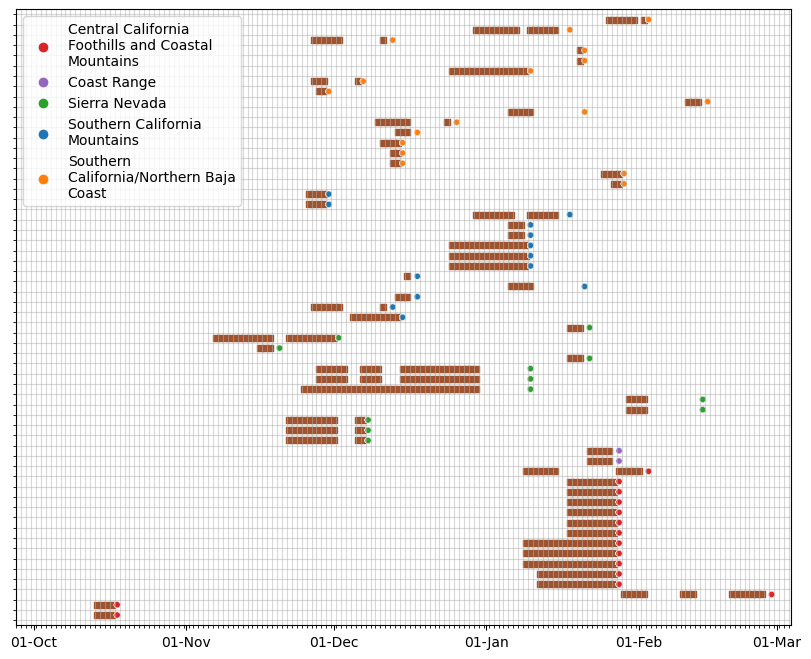

In [9]:
#plot 

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(x = cluster_wetyear.day_window, y= cluster_wetyear.new_event_number, marker='s', s=20, c='sienna')
ax.set_xlim(270,427)
ax.set_ylim(-1,event_number_wetyear)
ax2 = sns.scatterplot(x = cluster_wetyear.event_date_day, y= cluster_wetyear.new_event_number, hue =cluster_wetyear.region, s=20)
handles, labels = ax2.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
label = [ '\n'.join(textwrap.wrap(i,26.5)) for i in labels]
#print(label)
label[0:]
legend = ax2.legend(handles=handles[0:], labels=label[0:])
sns.move_legend(ax2, "upper left", bbox_to_anchor=(0, 1))
date_form = DateFormatter("%d-%b")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
#these ticks are based on final day assigned to cluster events
ax.set_xticks(np.arange(270,427+1)-0.5, minor=True)
#xticks[-1].set_visible(False)
ax.set_yticks([])
ax.set_yticks(np.arange(event_number_wetyear+1)-0.5, minor=True)
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid(True, which = 'minor',alpha = 0.5)